In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D


In [2]:
desired_cols = ['osg_fish1_x','osg_fish1_y', 'osg_fish1_z','framenumber','real_fish_x', 'real_fish_y', 'real_fish_z','velocity', 'Stim_Flag', 'Stim_Flag_dir', 'exp_uuid', 'frame_diff', 'steps',
       'xs_rf', 'ys_rf', 'zs_rf']
df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


C:\Users\kkumari\AppData\Local\Temp\ipykernel_23724\1761184208.py:3: DtypeWarning: Columns (4,5,6,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


In [3]:
def calc_proximity(df, proximity_threshold=0.03):
    df = df.dropna()
    x_rf, y_rf, z_rf = pd.to_numeric(df['xs_rf']), pd.to_numeric(df['ys_rf']), pd.to_numeric(df['zs_rf'])
    x_vf, y_vf, z_vf = pd.to_numeric(df['osg_fish1_x']), pd.to_numeric(df['osg_fish1_y']), pd.to_numeric(df['osg_fish1_z'])

    df.loc[:, 'x_rf'] = x_rf
    df.loc[:, 'y_rf'] = y_rf
    df.loc[:, 'z_rf'] = z_rf
    df.loc[:, 'x_vf'] = x_vf
    df.loc[:, 'y_vf'] = y_vf
    df.loc[:, 'z_vf'] = z_vf
    

    df['euclidean_distance'] = np.sqrt((x_rf - x_vf) ** 2 + (y_rf - y_vf) ** 2 + (z_rf - z_vf) ** 2)
    df['proximity'] = df['euclidean_distance'] < proximity_threshold

    print(f'proximity first 10 rows: {df["proximity"].head(10)}')

    return df

In [4]:
def calc_relative_heading(df, angular_threshold_degrees=180):

    df = calc_proximity(df, proximity_threshold=0.03)

    df = df.dropna()
    df['dxs_rf'] = df['x_rf'].diff()
    df['dys_rf'] = df['y_rf'].diff()
    df['dxs_vf'] = df['x_vf'].diff()
    df['dys_vf'] = df['y_vf'].diff()

    df['heading_rf'] = np.arctan2(df['dys_rf'], df['dxs_rf'])
    df['heading_vf'] = np.arctan2(df['dys_vf'], df['dxs_vf'])

    df['heading_rf'].fillna(0, inplace=True)
    df['heading_vf'].fillna(0, inplace=True)

    heading_rf = df['heading_rf']
    heading_vf = df['heading_vf']

    unwrap_heading_rf = np.unwrap(np.array(heading_rf))
    unwrap_heading_vf = np.unwrap(np.array(heading_vf))

    relative_angle = unwrap_heading_rf - unwrap_heading_vf
    relative_angle_complement = np.mod(relative_angle + np.pi, 2 * np.pi) - np.pi

    concat_relative_angles = np.vstack((relative_angle, relative_angle_complement))
    concat_abs_relative_angles = np.abs(concat_relative_angles)

    min_indices_relative = np.argmin(concat_abs_relative_angles, axis=0)
    relative_heading = concat_relative_angles[min_indices_relative, np.arange(concat_relative_angles.shape[1])]

    df['relative_heading'] = relative_heading

    angular_threshold_radians = np.radians(angular_threshold_degrees)

    # angular_threshold_radians = np.radians(angular_threshold_degrees)
    # df['following'] = np.abs(relative_heading) <= angular_threshold_radians

    angular_threshold_radians = np.radians(angular_threshold_degrees)
    following = np.abs(relative_heading) <= angular_threshold_radians

    print(f'following first 10 rows: {following[:10]}')
    df['following'] = following
    percent_following = np.mean(following) * 100
    print(f'Percent following: {percent_following:.2f}%')
    
    return df

In [5]:
def coordinate_transition(df, heading_vf):
    x_in, y_in = df['x_rf'] - df['x_vf'], df['y_rf'] - df['y_vf']
    x_o = x_in * np.cos(heading_vf) + y_in * np.sin(heading_vf)
    y_o = -x_in * np.sin(heading_vf) + y_in * np.cos(heading_vf)

    df['x_o'] = x_o
    df['y_o'] = y_o

    print(f'x_o: {x_o[:10]}')
    print(f'y_o: {y_o[:10]}')

    return df

In [6]:
def rf_behind_vf(df, x_limit=0, y_limit=0):

    df = calc_relative_heading(df, angular_threshold_degrees=30)

    vf_heading = df['heading_vf'].values

    df = coordinate_transition(df, vf_heading)
    df['rf_behind_vf'] = (df['x_o'] < x_limit) & (df['y_o'] < y_limit)
    rf_behind_vf = df['rf_behind_vf'].values
    print(f'first 10 rows of rf_behind_vf: {rf_behind_vf[:10]}')
    print(f'proportion of time fish is behind: {np.mean(rf_behind_vf)}')

    return df

In [7]:
def frames30_following(df, streak_length_threshold=30):
    # Use the boolean values directly
    all_conditions = df['following'] & df['proximity'] & df['rf_behind_vf']

    streak_lengths = []
    counter = 0
    for value in all_conditions:
        if value:
            counter += 1
        else:
            if counter >= streak_length_threshold:
                streak_lengths.append(counter)
            counter = 0
    if counter >= streak_length_threshold:
        streak_lengths.append(counter)

    streaks_over_threshold = np.array(streak_lengths)

    print(f'streaks over threshold: {streaks_over_threshold}')
    print(f'number of streaks over threshold: {len(streaks_over_threshold)}')

    return streaks_over_threshold


In [8]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

In [9]:
def plot_data(df):
    # 3D scatter plot of positions
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x_rf'], df['y_rf'], df['z_rf'], c='r', marker='o', label='Real Fish', s=0.2)
    ax.scatter(df['x_vf'], df['y_vf'], df['z_vf'], c='b', marker='^', label='Virtual Fish', s= 0.2)
    ax.legend()
    # plt.show()

    # Histogram of euclidean distances
    fig = plt.figure()
    plt.hist(df['euclidean_distance'], bins=100, label='Euclidean Distance')
    plt.legend()
    plt.show()

    # Plot of proximity over time
    fig = plt.figure()
    plt.plot(df['proximity'], label='Proximity')
    plt.legend()
    plt.show()

    # Plot of relative heading over time
    fig = plt.figure(figsize=(15, 5))
    plt.plot(df['relative_heading'], label='Relative Heading')
    plt.legend()
    plt.show()

    # Plot of following over time (first 1000 data points)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(df['following'][:1000], label='Following')
    plt.legend()
    plt.show()

    # Histogram of relative heading
    fig = plt.figure(figsize=(15, 5))
    plt.hist(df['relative_heading'], bins=100, label='Relative Heading')
    plt.legend()
    plt.show()

    # Histogram of streaks over 30
    streaks_over_30 = frames30_following(df, 30)
    fig = plt.figure(figsize=(15, 5))
    plt.hist(streaks_over_30, bins=100, label='Streaks Over 30')
    plt.xlabel('Streak Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Streak Lengths Over 30')
    plt.legend()
    plt.show()

In [10]:
rf_behind_vf_df= rf_behind_vf(df, x_limit=0, y_limit=0)

C:\Users\kkumari\AppData\Local\Temp\ipykernel_23724\3660890724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x_rf'] = x_rf
C:\Users\kkumari\AppData\Local\Temp\ipykernel_23724\3660890724.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y_rf'] = y_rf
C:\Users\kkumari\AppData\Local\Temp\ipykernel_23724\3660890724.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

proximity first 10 rows: 8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
Name: proximity, dtype: bool
following first 10 rows: [ True False False False False False False False False False]
Percent following: 24.23%
x_o: 8    -0.059992
9    -0.059818
10   -0.059650
11   -0.059488
12   -0.059332
13   -0.059182
14   -0.059033
15   -0.058890
16   -0.058752
17   -0.058618
dtype: float64
y_o: 8    -0.067762
9    -0.067406
10   -0.067062
11   -0.066727
12   -0.066404
13   -0.066093
14   -0.065788
15   -0.065496
16   -0.065213
17   -0.064936
dtype: float64
first 10 rows of rf_behind_vf: [ True  True  True  True  True  True  True  True  True  True]
proportion of time fish is behind: 0.2709067173579461


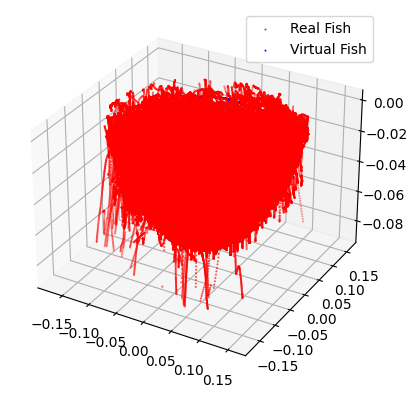

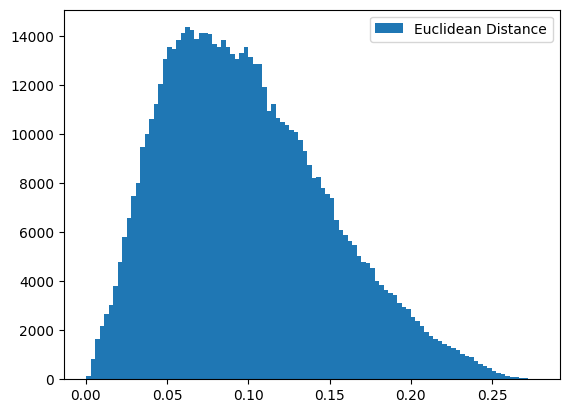

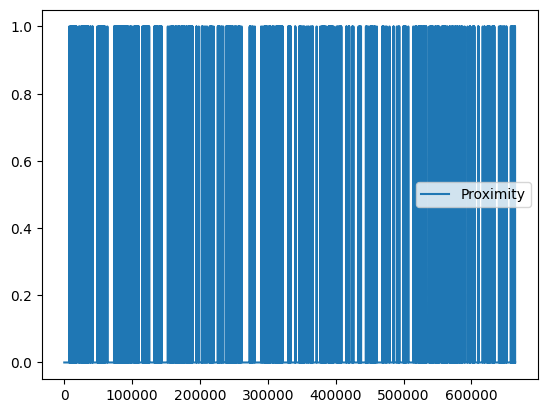

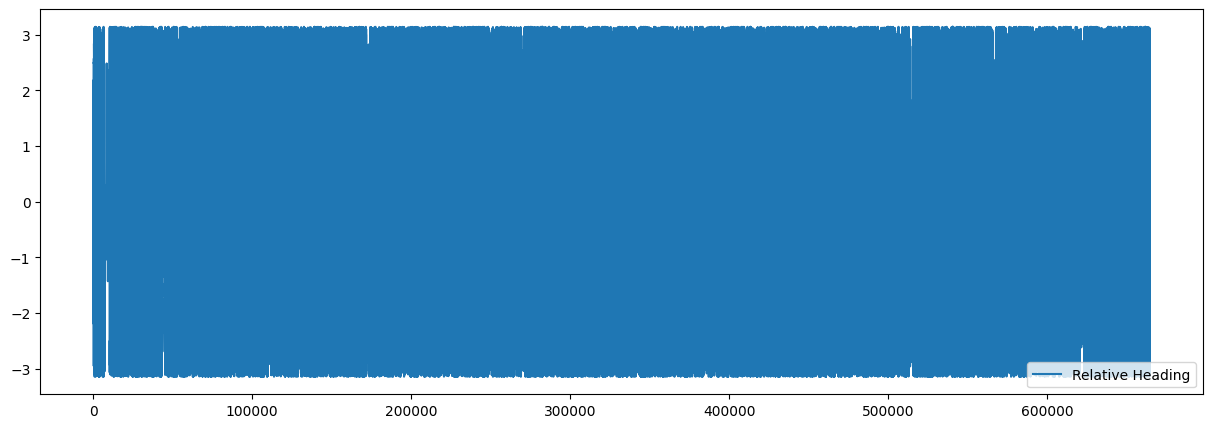

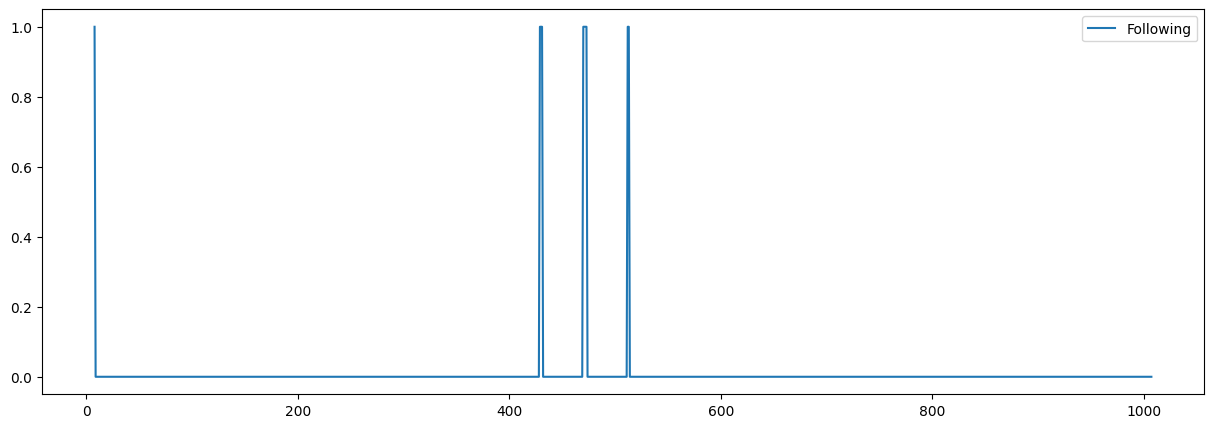

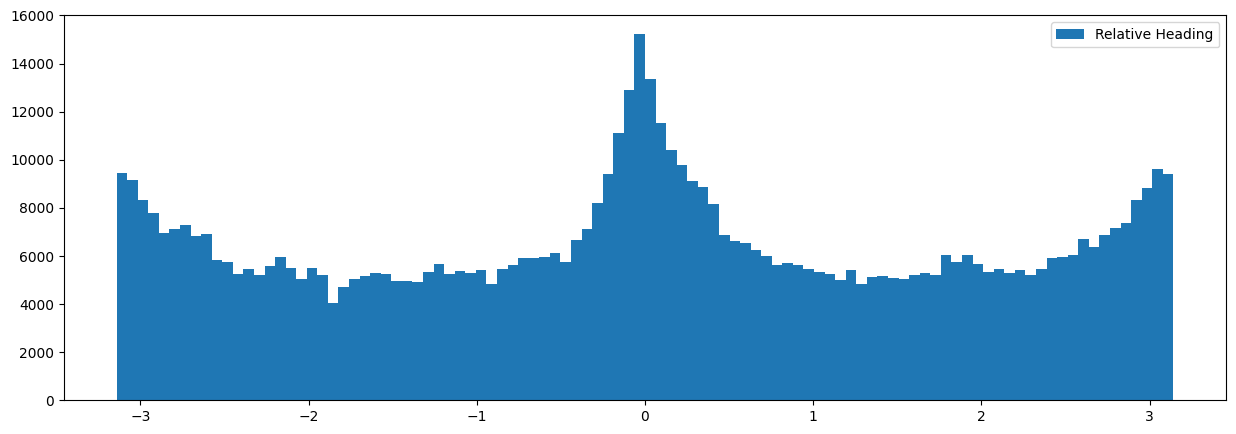

streaks over threshold: [ 35 121  66  93  31  56  83  37  51 106  48  41  83  31  63]
number of streaks over threshold: 15


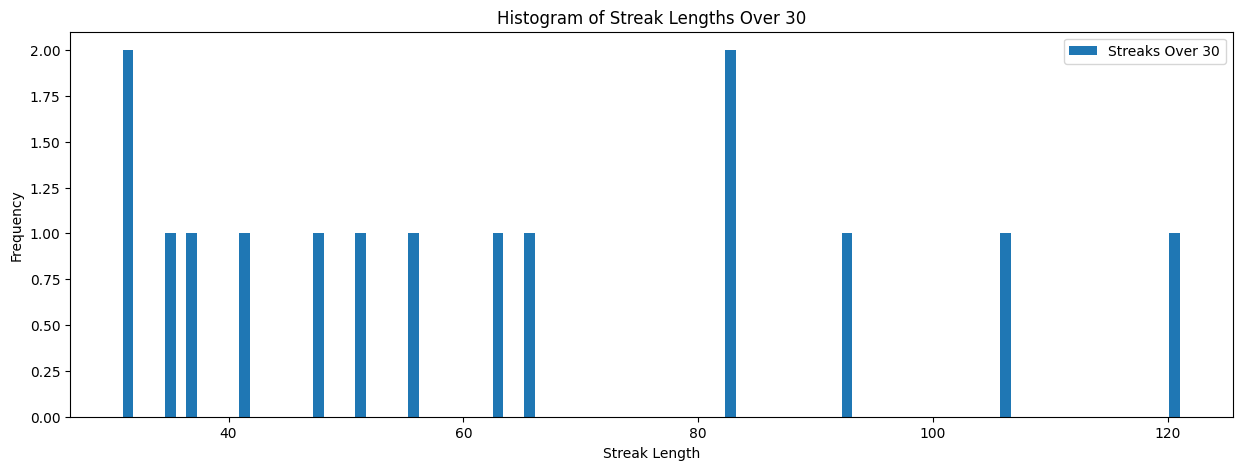

In [11]:
plot_data(rf_behind_vf_df)